## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [18]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [22]:
from datasets import load_dataset

load_entire_dataset = True

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150", trust_remote_code=True)

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]


DatasetGenerationError: An error occurred while generating the dataset

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [9]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [30]:
from transformers import SegformerImageProcessor

root_dir = 'C:/Users/Jacob Sauther/OneDrive/Documents/GitHub/js-spring-cs5567/Final/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [31]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [32]:
encoded_inputs = train_dataset[0]

In [33]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [34]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [35]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [36]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [38]:
batch = next(iter(train_dataloader))

In [39]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [40]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [41]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [42]:
batch["labels"][mask]

tensor([12, 12, 12,  ...,  3,  3,  3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [35]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

c:\Users\Jacob Sauther\OneDrive\Documents\GitHub\js-spring-cs5567\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.lin

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [36]:
import evaluate

metric = evaluate.load("mean_iou")

In [37]:
image_processor.do_reduce_labels

True

In [39]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4069403111934662
Mean_iou: 0.3750123243299845
Mean accuracy: 0.4129526407623569
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23023368418216705
Mean_iou: 0.8563757273868202
Mean accuracy: 0.8796256337148526
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3509402871131897
Mean_iou: 0.356793523982799
Mean accuracy: 0.4504340816873312
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23480930924415588
Mean_iou: 0.8537509534321146
Mean accuracy: 0.8791390115857182
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19166333973407745
Mean_iou: 0.8614473593056612
Mean accuracy: 0.8847307804361225
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26203736662864685
Mean_iou: 0.8150773658533724
Mean accuracy: 0.9281680404597432
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4218025505542755
Mean_iou: 0.3069304482235083
Mean accuracy: 0.400011594587264
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29995644092559814
Mean_iou: 0.634227512329795
Mean accuracy: 0.6727038897116083
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11550954729318619
Mean_iou: 0.8542231934016337
Mean accuracy: 0.869655030923572
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23376496136188507
Mean_iou: 0.5885560981117014
Mean accuracy: 0.6856507348276245
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13858099281787872
Mean_iou: 0.5046097893521151
Mean accuracy: 0.7850851516261679
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27825766801834106
Mean_iou: 0.660248692897902
Mean accuracy: 0.7086279308210034
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13472820818424225
Mean_iou: 0.613450562712753
Mean accuracy: 0.6659265857134888
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23231428861618042
Mean_iou: 0.627614747667957
Mean accuracy: 0.6724697335577573
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3486810028553009
Mean_iou: 0.435379450724147
Mean accuracy: 0.46666880187839416
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15137866139411926
Mean_iou: 0.943695375608356
Mean accuracy: 0.9764799200063469
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1505471020936966
Mean_iou: 0.45815603576533803
Mean accuracy: 0.6753914614531377
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08058890700340271
Mean_iou: 0.9574272999814432
Mean accuracy: 0.9675901633524088
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2551385462284088
Mean_iou: 0.48379216294320476
Mean accuracy: 0.6122612072681218
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3408972918987274
Mean_iou: 0.3777734844295035
Mean accuracy: 0.43282932190330176
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13927175104618073
Mean_iou: 0.9493754919757387
Mean accuracy: 0.9680080156561941
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25306642055511475
Mean_iou: 0.6676109229934861
Mean accuracy: 0.7105196038671996
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35252049565315247
Mean_iou: 0.37194078349585263
Mean accuracy: 0.45624511527495565
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13407853245735168
Mean_iou: 0.8102508323981655
Mean accuracy: 0.9361652785424035
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28494277596473694
Mean_iou: 0.5372433897729195
Mean accuracy: 0.6031970763422518
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11167725175619125
Mean_iou: 0.8933052215527417
Mean accuracy: 0.9126641345347676
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1003744900226593
Mean_iou: 0.6598903976229089
Mean accuracy: 0.7034526183335597
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12449219077825546
Mean_iou: 0.7647911457569457
Mean accuracy: 0.7955481559240574
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14682111144065857
Mean_iou: 0.48435571387726123
Mean accuracy: 0.6859823378263433
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12271025031805038
Mean_iou: 0.5030002799000319
Mean accuracy: 0.7732932374048588
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22812055051326752
Mean_iou: 0.5826003272776569
Mean accuracy: 0.6399541548739884
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0832364559173584
Mean_iou: 0.5192958442574885
Mean accuracy: 0.7252484701315377
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21850590407848358
Mean_iou: 0.6456974603499452
Mean accuracy: 0.7396964354022669
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14032550156116486
Mean_iou: 0.5360882277598227
Mean accuracy: 0.7660373190796463
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12038349360227585
Mean_iou: 0.4670496187847822
Mean accuracy: 0.6945110276882221
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27821627259254456
Mean_iou: 0.3970602196205203
Mean accuracy: 0.46909198081550907
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11411254107952118
Mean_iou: 0.8175446473001959
Mean accuracy: 0.9451257011993379
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1540909707546234
Mean_iou: 0.7017363148176194
Mean accuracy: 0.7774700626607751
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18808068335056305
Mean_iou: 0.4229064925211405
Mean accuracy: 0.6236895846813187
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21580453217029572
Mean_iou: 0.6831726546582528
Mean accuracy: 0.7239016321332622
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24667233228683472
Mean_iou: 0.513971961457094
Mean accuracy: 0.7250824792210001
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08087031543254852
Mean_iou: 0.5229168724004183
Mean accuracy: 0.7641390049753631
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17285270988941193
Mean_iou: 0.7347391743338036
Mean accuracy: 0.7827583104709616
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22117304801940918
Mean_iou: 0.47971022272242614
Mean accuracy: 0.515422444732091
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22817474603652954
Mean_iou: 0.45027571697846064
Mean accuracy: 0.4964887025021762
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.325495183467865
Mean_iou: 0.4594899803688974
Mean accuracy: 0.4992299102531249
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1173952966928482
Mean_iou: 0.8133130729233004
Mean accuracy: 0.9377530824858649
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13458459079265594
Mean_iou: 0.7219490864221648
Mean accuracy: 0.7978850082801633
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20406541228294373
Mean_iou: 0.7473043604686752
Mean accuracy: 0.7759926582827772
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07939377427101135
Mean_iou: 0.5495306037352039
Mean accuracy: 0.7851735349466682
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09773826599121094
Mean_iou: 0.9243691270117744
Mean accuracy: 0.9394838051126425
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12968109548091888
Mean_iou: 0.7241227422306454
Mean accuracy: 0.7976070306146937
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1128995418548584
Mean_iou: 0.4206387523550278
Mean accuracy: 0.6680577484160494
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0813823938369751
Mean_iou: 0.9281996547439771
Mean accuracy: 0.9700246402585125
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22782519459724426
Mean_iou: 0.41886276315385434
Mean accuracy: 0.4699374087610715
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24616745114326477
Mean_iou: 0.4789395713045317
Mean accuracy: 0.5135840230465542
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08834397792816162
Mean_iou: 0.9535809669784955
Mean accuracy: 0.9718886735743725
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21938805282115936
Mean_iou: 0.4258218723597708
Mean accuracy: 0.5104165307373106
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08528782427310944
Mean_iou: 0.9506808554436051
Mean accuracy: 0.9676710613108567
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.037002403289079666
Mean_iou: 0.3939272243848393
Mean accuracy: 0.7457440202017205
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16616466641426086
Mean_iou: 0.7205919807129568
Mean accuracy: 0.7862311072280809
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15830306708812714
Mean_iou: 0.7447456439326893
Mean accuracy: 0.7956774121626179
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18932469189167023
Mean_iou: 0.2670265024281559
Mean accuracy: 0.41536255434969954
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13027450442314148
Mean_iou: 0.8458211855848136
Mean accuracy: 0.8825596000483948
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07012008875608444
Mean_iou: 0.892032995949142
Mean accuracy: 0.9723469250606007
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11375578492879868
Mean_iou: 0.712067908751838
Mean accuracy: 0.7979418237384809
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15688247978687286
Mean_iou: 0.5790190397139879
Mean accuracy: 0.6993926502438037
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12974166870117188
Mean_iou: 0.7679951054978315
Mean accuracy: 0.8514277291119173
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17342494428157806
Mean_iou: 0.6588896744791616
Mean accuracy: 0.6912845071996182
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19522973895072937
Mean_iou: 0.4508809537492166
Mean accuracy: 0.513727482458784
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1690826267004013
Mean_iou: 0.6656466869296648
Mean accuracy: 0.702244163075087
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1300400048494339
Mean_iou: 0.7502729142481314
Mean accuracy: 0.7954194731590362
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24497881531715393
Mean_iou: 0.4648857071080087
Mean accuracy: 0.5252672593492268
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03151020035147667
Mean_iou: 0.9083794977856232
Mean accuracy: 0.91682896795595
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04720662906765938
Mean_iou: 0.4932222065702028
Mean accuracy: 0.7724231129922189
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15829810500144958
Mean_iou: 0.3234960362697965
Mean accuracy: 0.4691317926183699
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1734771579504013
Mean_iou: 0.5948981050804353
Mean accuracy: 0.6535247811881537
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16445161402225494
Mean_iou: 0.6055860752094431
Mean accuracy: 0.6914555860017295
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07156512886285782
Mean_iou: 0.8716497045094959
Mean accuracy: 0.8882406369346408
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08354650437831879
Mean_iou: 0.7717062047433869
Mean accuracy: 0.796988241079097
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0329037569463253
Mean_iou: 0.9380586655626221
Mean accuracy: 0.9478816427423093
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11683893948793411
Mean_iou: 0.7802035900992543
Mean accuracy: 0.8095456354460469
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14892935752868652
Mean_iou: 0.7988915618142265
Mean accuracy: 0.9279403423112583
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22137735784053802
Mean_iou: 0.678351840738522
Mean accuracy: 0.7120528932781033
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12707114219665527
Mean_iou: 0.7965273316717698
Mean accuracy: 0.830040035870527
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0832139328122139
Mean_iou: 0.39208187860925453
Mean accuracy: 0.6945183668472189
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.034829918295145035
Mean_iou: 0.4534615614737819
Mean accuracy: 0.7431608540572905
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1360989660024643
Mean_iou: 0.7859982487474049
Mean accuracy: 0.8158083802069251
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05061163753271103
Mean_iou: 0.5266471983118037
Mean accuracy: 0.7859426542760588
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06383015215396881
Mean_iou: 0.8856490355618845
Mean accuracy: 0.9043400162023513
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12265703827142715
Mean_iou: 0.482285450655568
Mean accuracy: 0.6626588135254842
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25600555539131165
Mean_iou: 0.40481759773028
Mean accuracy: 0.5084786620390541
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20492316782474518
Mean_iou: 0.511555054922582
Mean accuracy: 0.547927502134314
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08096230775117874
Mean_iou: 0.5377634728887959
Mean accuracy: 0.7876191213286843
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04949032887816429
Mean_iou: 0.48520815788795396
Mean accuracy: 0.7899111597821679
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1780809462070465
Mean_iou: 0.5264640164749889
Mean accuracy: 0.5769269808354197
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.048149753361940384
Mean_iou: 0.4824238347936423
Mean accuracy: 0.7629960057263695
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.024050159379839897
Mean_iou: 0.9359598575393875
Mean accuracy: 0.9483982102117031
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09194833785295486
Mean_iou: 0.7334521894250801
Mean accuracy: 0.7717558101139382
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0747581422328949
Mean_iou: 0.9455525638826164
Mean accuracy: 0.9695006229578295
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21194884181022644
Mean_iou: 0.5139723233827981
Mean accuracy: 0.5533234593028246
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10495276749134064
Mean_iou: 0.7196703891907199
Mean accuracy: 0.7583822078037934
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06871018558740616
Mean_iou: 0.9704356746752734
Mean accuracy: 0.9807347224311189
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10078736394643784
Mean_iou: 0.4878254028307294
Mean accuracy: 0.6621558611807262
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10836575925350189
Mean_iou: 0.8000077274417278
Mean accuracy: 0.8535591465748181
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2289278507232666
Mean_iou: 0.5143577112116052
Mean accuracy: 0.5520317067502366
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03719811886548996
Mean_iou: 0.9284828437271627
Mean accuracy: 0.969923711373383
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14599542319774628
Mean_iou: 0.6300629034426425
Mean accuracy: 0.6959893872704674
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06105034425854683
Mean_iou: 0.9194650464452266
Mean accuracy: 0.9365214568683244
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0915989950299263
Mean_iou: 0.7823438128152984
Mean accuracy: 0.8160839937977564
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21212294697761536
Mean_iou: 0.5258860002546129
Mean accuracy: 0.570185592386131
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24082015454769135
Mean_iou: 0.5080180192679802
Mean accuracy: 0.5446940621825889
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07446592301130295
Mean_iou: 0.9335466121686261
Mean accuracy: 0.9620923804722886
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12564390897750854
Mean_iou: 0.6763814044294373
Mean accuracy: 0.7040831823688677
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03787937015295029
Mean_iou: 0.5703028450137553
Mean accuracy: 0.7711366936737813
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06023606285452843
Mean_iou: 0.5261044209900438
Mean accuracy: 0.7699433186328191
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17101746797561646
Mean_iou: 0.5605608470360226
Mean accuracy: 0.6011252767388714
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19644036889076233
Mean_iou: 0.6617716313017669
Mean accuracy: 0.6996814399302127
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05733295530080795
Mean_iou: 0.9274949367302504
Mean accuracy: 0.9493067030410824
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12813632190227509
Mean_iou: 0.4042984116718111
Mean accuracy: 0.5323118532183124
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0714191421866417
Mean_iou: 0.8982196078071117
Mean accuracy: 0.9274175820581525
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07287795096635818
Mean_iou: 0.5195917831505867
Mean accuracy: 0.7625311955299299
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07859160751104355
Mean_iou: 0.8227410197625102
Mean accuracy: 0.8559037182044519
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06003088876605034
Mean_iou: 0.5540609261294994
Mean accuracy: 0.7798627040333077
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12427058815956116
Mean_iou: 0.7558634274462843
Mean accuracy: 0.7995011802576192
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15159672498703003
Mean_iou: 0.6682223330537274
Mean accuracy: 0.72364807829754
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03641073405742645
Mean_iou: 0.9618749255249124
Mean accuracy: 0.9796301953195731
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07893627882003784
Mean_iou: 0.8833784848608535
Mean accuracy: 0.914405610757426
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07689875364303589
Mean_iou: 0.836048832190034
Mean accuracy: 0.8811685708275987
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1429576724767685
Mean_iou: 0.6181684758144904
Mean accuracy: 0.6673780705431709
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.01865989901125431
Mean_iou: 0.9874201475821489
Mean accuracy: 0.9955646074504854
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08294018357992172
Mean_iou: 0.7828796255183282
Mean accuracy: 0.8143685055114862
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06909551471471786
Mean_iou: 0.8588000185778281
Mean accuracy: 0.8867877452643188
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05971826612949371
Mean_iou: 0.902886843462459
Mean accuracy: 0.9230069745990923
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14912620186805725
Mean_iou: 0.6022028461737151
Mean accuracy: 0.640626684746132
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08058696985244751
Mean_iou: 0.8355653711749237
Mean accuracy: 0.8772836216831787
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03238306939601898
Mean_iou: 0.5311423231901361
Mean accuracy: 0.7876938230081297
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05885320156812668
Mean_iou: 0.854875942908575
Mean accuracy: 0.8912250035622211
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05484221503138542
Mean_iou: 0.869375978392644
Mean accuracy: 0.8907501931008762
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09861656278371811
Mean_iou: 0.7002427012579006
Mean accuracy: 0.7301344021330918
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1502467840909958
Mean_iou: 0.5712316021203638
Mean accuracy: 0.6089688885558624
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03536589816212654
Mean_iou: 0.9277698298827518
Mean accuracy: 0.9390624876312289
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12634910643100739
Mean_iou: 0.6853439319991756
Mean accuracy: 0.739408087681127
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07358310371637344
Mean_iou: 0.8385877784788732
Mean accuracy: 0.8763105858656094
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11801537871360779
Mean_iou: 0.6463592131843229
Mean accuracy: 0.7139850322928676
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.15136106312274933
Mean_iou: 0.5647114443715455
Mean accuracy: 0.6309711051795188
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12967762351036072
Mean_iou: 0.6996233872296475
Mean accuracy: 0.7343379998818222
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13535192608833313
Mean_iou: 0.5438565266991693
Mean accuracy: 0.5895711153976815
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.132644385099411
Mean_iou: 0.5020309661617002
Mean accuracy: 0.6106875392169857
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.015658404678106308
Mean_iou: 0.9894227668946382
Mean accuracy: 0.9951260227153984
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.029830340296030045
Mean_iou: 0.6199184218606739
Mean accuracy: 0.8152687610940703
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06960254907608032
Mean_iou: 0.8866837164787924
Mean accuracy: 0.9174769812785755
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0425681546330452
Mean_iou: 0.8476818503656868
Mean accuracy: 0.9740904317078775
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1035429835319519
Mean_iou: 0.4417141640761566
Mean accuracy: 0.5698465133214814
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12734830379486084
Mean_iou: 0.7315600117371285
Mean accuracy: 0.764828237845952
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.018829092383384705
Mean_iou: 0.6790454673785944
Mean accuracy: 0.7723454717577396
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13267791271209717
Mean_iou: 0.591923791147539
Mean accuracy: 0.6242295133305809
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12654665112495422
Mean_iou: 0.6103872724199549
Mean accuracy: 0.6490020143411378
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03919978067278862
Mean_iou: 0.9462523670688964
Mean accuracy: 0.9630425349977628
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16870631277561188
Mean_iou: 0.5463255381290592
Mean accuracy: 0.5938922337566287
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.030248232185840607
Mean_iou: 0.9532435828882551
Mean accuracy: 0.974189940782375
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10206480324268341
Mean_iou: 0.6956198663729433
Mean accuracy: 0.7286741848418785
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.043238572776317596
Mean_iou: 0.7523982200620807
Mean accuracy: 0.8327371831569512
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.02877197600901127
Mean_iou: 0.9531639272517969
Mean accuracy: 0.9734803366833406
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1060897558927536
Mean_iou: 0.7257626732130885
Mean accuracy: 0.7516031083124678
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12549415230751038
Mean_iou: 0.4011822191863282
Mean accuracy: 0.5122759557578341
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07585487514734268
Mean_iou: 0.7421070726338121
Mean accuracy: 0.7681492471424024
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09736699610948563
Mean_iou: 0.46418419504043756
Mean accuracy: 0.5624869702970002
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.029915913939476013
Mean_iou: 0.569579971670906
Mean accuracy: 0.7684423764267988
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.01614381931722164
Mean_iou: 0.9544209648317399
Mean accuracy: 0.9869934956067915
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09678646922111511
Mean_iou: 0.7359516392902052
Mean accuracy: 0.766946308395603
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05100037530064583
Mean_iou: 0.8659489009974446
Mean accuracy: 0.8887634848147986
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.032826002687215805
Mean_iou: 0.9494967062886953
Mean accuracy: 0.9595961576424333
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.017919141799211502
Mean_iou: 0.6137811311561884
Mean accuracy: 0.7759899978872161
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09356639534235
Mean_iou: 0.7258421104322791
Mean accuracy: 0.7641440020833721
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05134601891040802
Mean_iou: 0.6742955935192076
Mean accuracy: 0.7752437823582622
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08535205572843552
Mean_iou: 0.7751022210737227
Mean accuracy: 0.874656973888694
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09081414341926575
Mean_iou: 0.517949894402405
Mean accuracy: 0.6018319580520468
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05319342762231827
Mean_iou: 0.871089242732012
Mean accuracy: 0.8952161370846436
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.048074789345264435
Mean_iou: 0.8167988137296753
Mean accuracy: 0.8899932981433718
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06832057982683182
Mean_iou: 0.6546307649050691
Mean accuracy: 0.6792861232852254
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06404667347669601
Mean_iou: 0.9350121224239085
Mean accuracy: 0.9601285347502149
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06314074248075485
Mean_iou: 0.8346776442430786
Mean accuracy: 0.8636199383514832
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11832660436630249
Mean_iou: 0.5715900396097426
Mean accuracy: 0.639233483140534
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09824488312005997
Mean_iou: 0.8011326136303061
Mean accuracy: 0.8701011031015808
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04429458826780319
Mean_iou: 0.7305762146147914
Mean accuracy: 0.8014173045487593
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07511022686958313
Mean_iou: 0.8093966569715544
Mean accuracy: 0.9400954932318123
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.08954489231109619
Mean_iou: 0.6437286251236304
Mean accuracy: 0.7190102720680438
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.03678756207227707
Mean_iou: 0.9542645402047711
Mean accuracy: 0.9761461738953138
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1123373880982399
Mean_iou: 0.6373659850558945
Mean accuracy: 0.7034116944171155
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.04516669362783432
Mean_iou: 0.8273550984767832
Mean accuracy: 0.9098884617293854
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0794917494058609
Mean_iou: 0.7206173403976093
Mean accuracy: 0.7484627558492825
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.09603945165872574
Mean_iou: 0.6979998860463458
Mean accuracy: 0.7426917505927706
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.015064682811498642
Mean_iou: 0.9855259285969775
Mean accuracy: 0.9957265703098318
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.051535796374082565
Mean_iou: 0.9133025600339368
Mean accuracy: 0.9361842344637997
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.06596305221319199
Mean_iou: 0.8693135832590129
Mean accuracy: 0.9037319853524122
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.045443981885910034
Mean_iou: 0.8182574205498303
Mean accuracy: 0.8446296151496473
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10906479507684708
Mean_iou: 0.7282629947023836
Mean accuracy: 0.7635248715827964
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3523496091365814
Mean_iou: 0.5534625464007662
Mean accuracy: 0.6478771875909359
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.05808038264513016
Mean_iou: 0.7499436981999535
Mean accuracy: 0.9632837617096117


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

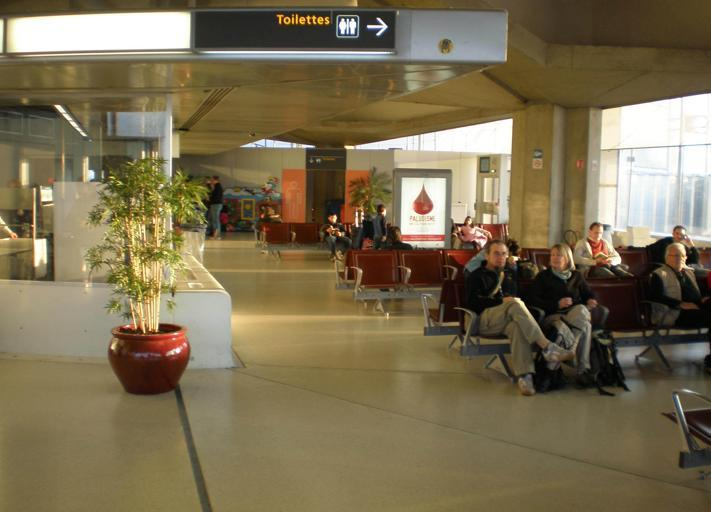

In [40]:
image = Image.open('C:/Users/Jacob Sauther/OneDrive/Documents/GitHub/js-spring-cs5567/Final/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [41]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [42]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [43]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [44]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [45]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


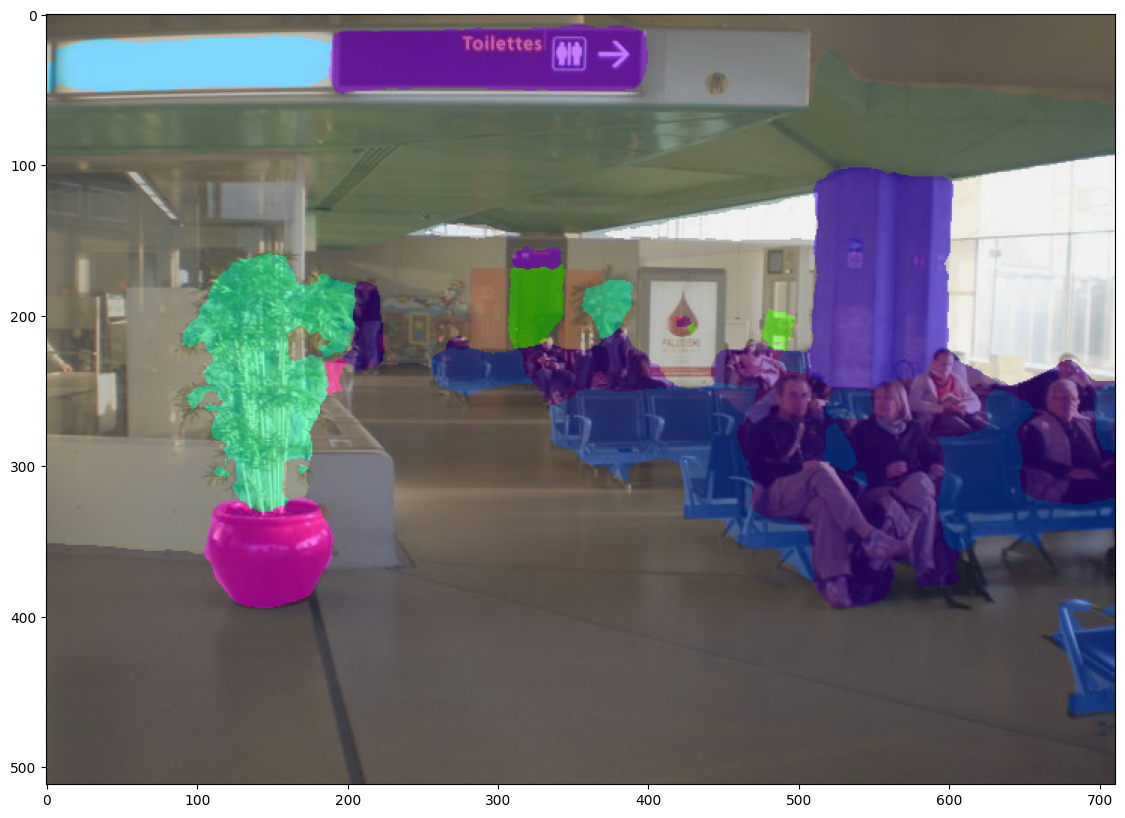

In [47]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

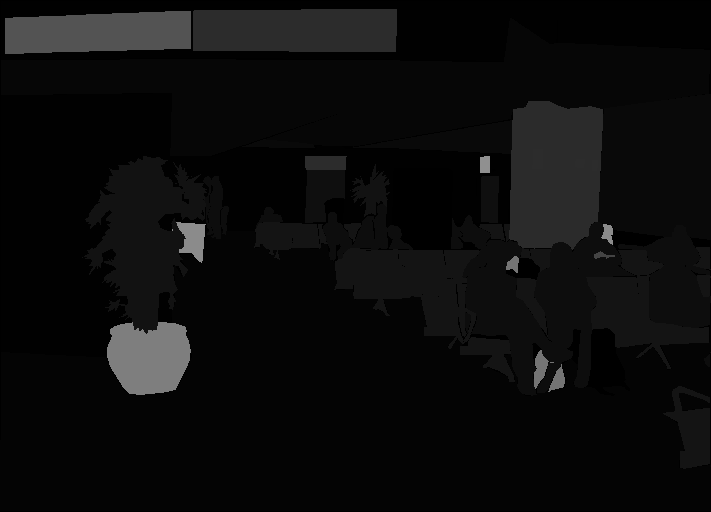

In [50]:
map = Image.open('C:/Users/Jacob Sauther/OneDrive/Documents/GitHub/js-spring-cs5567/Final/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


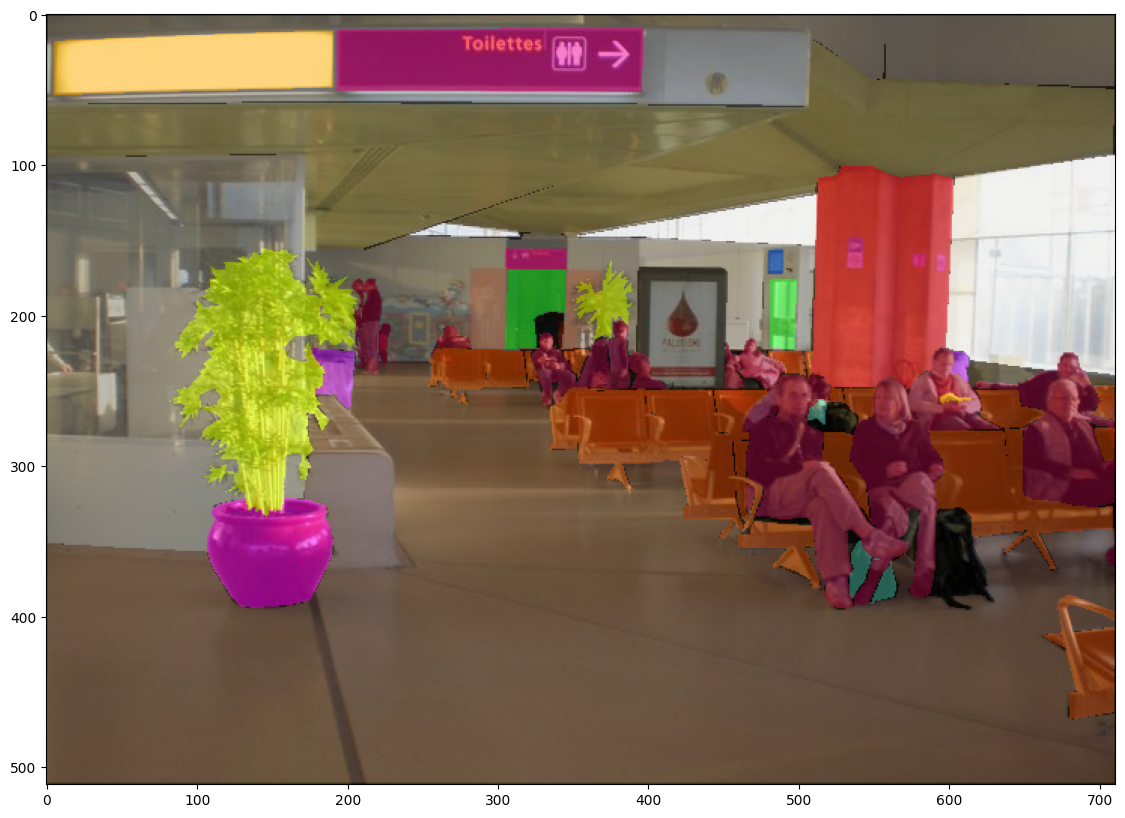

In [52]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [53]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

C:\Users\Jacob Sauther\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\Jacob Sauther\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [54]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [55]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.674526850843604
mean_accuracy 0.7045768445781408
overall_accuracy 0.957294003940162
---------------------
per-category metrics:


IoU  accuracy
wall      0.893508  0.980709
building       NaN       NaN
sky            NaN       NaN
floor     0.981713  0.992195
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

In [ ]:
metric_table